# Learning from the data

In the last notebook (5.3), we created the feature vector that we want to use to learn the conditions that lead to regulations. In this notebook, we will load the dataset, select the most promising features, normalize and scale them, and finally run a classifier on them.

As the goal of the thesis is to discuss the learnability of the problem and not to acheive production-grade performance, we will use the well-known basic algorithms provided by the Python package [scikit-learn](www.scikit-learn.org). The following picture (http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) provides a "path" through the variety of algorithms available in the library. It should be noted that (deep) Neural Networks are not at the heart of the scikit-learn library.

<img src="images/ml_map.png",width=85%,height=85%>

# 0. Imports

In [62]:
import os.path, pandas as pd 
import matplotlib as mp, matplotlib.pyplot as plt
import numpy as np, json, random, ast
from IPython.display import clear_output
from pandas.io.json import json_normalize, read_json
from datetime import datetime
from IPython.display import HTML

import sklearn as skl
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory

#Set some parameters for nicer visualizations
pd.set_option('display.expand_frame_repr', False) #do not wrap the printout of Pandas DataFrames
pd.set_option('display.precision', 2)
pd.set_option('display.max_columns', 50)
mp.rcParams['figure.figsize'] = (15, 15)
mp.pyplot.style.use = 'fivethirtyeight'
%matplotlib inline

In [63]:
def plot_roc(y_test, y_pred, caption):
    fpr, tpr, thresholds = skl.metrics.roc_curve(y_test, y_pred, pos_label=1)
    roc_auc = skl.metrics.auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area ={0:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(caption)
    plt.legend(loc="lower right")
    plt.show();

In [64]:
dfmain = pd.read_csv('data/dffinal.csv', index_col=0)
dfmain['geojson'] = dfmain['geojson'].map(ast.literal_eval) #convert string to dict
dfmain['sta'] = pd.to_datetime(dfmain['sta'])
dfmain['end'] = pd.to_datetime(dfmain['end'])
dfmain['duration'] = pd.to_timedelta(dfmain['duration'])   
dfmain.sample()

,icao,s,iata,wkt,geojson,sta,end,duration,rwys,humidity,dewPoint,temperature,pressure,visibility,windBearing,windSpeed,windGust,precipIntensity,precipProbability,storm,dat.cape,dat.tempk,dat.press,dat.humi,dat.precip,crosswind,cap,demand,ratio,regulated
1629,LEPA,Place_Palma_de_Mallorca___Son_San_Juan,PMI,POINT (2.73888897895813 39.551666259765625),"{'type': 'Point', 'coordinates': [2.7388889789...",2016-04-10 16:00:00,2016-04-10 16:59:59,00:59:59,240,0.43,6.08,18.87,1009.2,11.19,170.0,4.93,0.0,0.05,0.05,0,0.0,17.3,100086.41,51.6,0.0,4.63,66,32.0,0.48,0


# 1. Some preconsiderations

In the last notebok (5.3) we made some basic analysis on the available wx and other parameters. Deriving from these insights, we could conclude that we are 1) dealing with an imbalanced problem, and 2) some wx parameters did not play a role for our subset of data from April 2016  for seasonal reasons (e.g. no storm data available). 

## a) Dealing with an imbalanced problem: Defining Evaluation Metrics

In many applications (e.g. fraud detection), the minority class contains the more important or costly events. The same applies to our problem, as has been commented by CRIDA in our interview. Therefore, the estimator should have the tendency to capture as many of the critical entries as possible, even at the cost of misclassifying uncritical entries. The simple accuracy metric is not sufficient for these types of problems, because if, like in our case, the problem is imbalanced so that 94% of the entries belong to one class, a completely naive classifier that would just classify all items as belonging to the majority class, would acheive an accuracy of 94%, but would classify 100% of the minority entries wrong.   The following  definitions adapted from [Fawcett, T: An introduction to ROC analysis](http://dx.doi.org/10.1016/j.patrec.200) help to formalize the problem and select the correct scoring methods. The confusion matrix allows us to define different metrics:

<img src="images/confusion_matrix_1.png">

We define a regulated event as belonging to the "positive class", the label encoded as 1 in the dataset, and a non-regulated event as belonging to the "negative class" with the label 0. Considering the reply from CRIDA, it is critical to catch as much of the regulated events as possible, even at the cost of having some false positives in the result set. Lets define this more exactly. Let $m$ be the total of observations. Let

$$
 \begin{align}
accuracy &= \frac{TP + TN}{m} \\
tp \ rate \ (recall) &= \frac{TP}{TP + FP} \\
fp \ rate &= \frac{FP}{FP + TN} 
\end{align}
 $$

We can now state that for our purposes, the $tp \ rate$ should be optimized, even at the expense of collecting some false positives. The classifiers will internally compute a class probability between 0 and 1 for each predicted outcome. For example, a certain dataset might be classified as "0.85 probability of being not regulated". By shifting the classification threshold away from 0.5, we can adjust the number of events that are classified as "positive", with the tradeoff of increasing ambiguity. If we plot $tp \ rate$ against $fp \ rate$ on a chart for each probability threshold, we get the so-called ROC-curve:

<img src="images/roccurve.png" width=30%,height=30%>

The goal of the ML process is to attain a high $tp \ rate$ and a low $fp \ rate$. Therefore, the more prononced the bend of the curve away from the luck line $f(x) = x$ is, the better the classifier. This "bending" can also be measured by the metric $AUC$, which stands for "area under the curve" and is literally the area under the ROC curve, the graph being normalized to having a total area of 1. An AUC of .5 would mean that there is no difference to guessing, and an AUC of 1 would represent the ideal classifier. The problem is _learnable_ if a definitive bend away from the luck line can be observed. We are dealing with an imbalanced dataset. To gain an initial understanding, we calculate a baseline first. This baseline represents the performance that would be acheived by a primitive classifier that classifies all entries as belonging to the majority class. 


## c) Dealing with non-relevant features

Our dataset contains only April 2016. As the Iberian peninsula is subject to seasonal climate changes, we do not have all possible weather conditions in our sample dataset. For example, we do not have storm conditions or freezing precipitation in our dataset. An experiment on a larger data basis should consider these variables, for our purpose here, we will omit them to reduce dimensionality.

## d) Other considerations (preprocessing, hyperparameters, cross validation)

The success of machine learning methods often used to be a lucky guess on which algorithms and parameters to choose. But the scikit-learn API makes it very easy to apply advanced learning methods to our model. We can perform a Grid Search on the hyperparameters so that the best hyperparameters are found for us. It is easy to implement cross-validation into the learning process. The following advanced techniques will be used:

#### Data Standardization
Data standardization has the purpose of leveling different features into a comparable numerical dimension. While _scaling_ levels the numerical range of the features across observations, _normalization_ refers to a transformation that yields individual observations to have a norm of 1 across its features. We will be using `sklearn` for this purpose. In `sklearn`, two different classes implement scaling, respectively: `MinMaxScaler` and `StandardScaler`. As described in the `sklearn` documentation, scaling is more common to preprocess data for Neural Nets, while normalization is being used for Support Vector Machines and alike. It should be noted that the scaling/normalization process (data transformation) should be learned from the training set, and only _applied_ to the test set. But because we are using k-fold cross validation, we would introduce errors if we would renormalize in each  fold. Therefore, the sklearn documentation advises to embed the normalization process into a `pipeline` which is an sklearn class that chains estimators together.

#### Cross Validation

From [Wikipedia: Cross Validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)): "Cross-validation, sometimes called rotation estimation, is a model validation technique for assessing how the results of a statistical analysis will generalize to an independent data set." Cross-validation allows us to divide the training set into a training and validation set, but still learn from the complete set by performing the division several times, each time differently:
<img src="images/K-fold_cross_validation_EN.jpg"> 


#### Pipelining

Pipelining is a method offered by scikit-learn that allows to bundle several data transformation steps together, with one final estimator class doing the classification/regression. This allows to call .fit() only once on the complete pipeline. 

#### Hyperparameter Tuning: Grid Search

Having constructed a classifier with the transformation/estimation pipeline, Grid Search allows us to train the classifier iteratively, each time with slightly different hyperparemeters. At the end, Grid Search will terminate with the estimators tuned to the best parameters found during training.


#### Oversampling for imbalanced Datasets

lorem ipsum

Apart from the correct analysis, different algorithmic methods are available to deal with imbalanced problems. Some examples are oversampling and undersampling. We are going to use a vanilla and an oversampled dataset to compare the results of the oversampling method. Oversampling works as follows:

  $$ \ demonstrate \ oversampling $$

# 2. Baseline Definition

Given the thoughts above, we select the useful features, and split the data into training and test sets (the pipelines later on will further split the training sets into cross-validation subsets). As the task is to find out if the dataset is learnable at all, the basline will be the naive classifier that always decides for the majority class. 

In [5]:
# 0. Create the feature matrix and label vector as numpy-Arrays.
X = np.array(dfmain[['humidity', 'dewPoint', 'temperature', 
                    'pressure', 'visibility', 'windSpeed', 
                    'precipIntensity', 'precipProbability', 
                    'dat.cape', 'crosswind', 'ratio']])
y = np.array(dfmain['regulated'])
X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

[[936   0]
 [ 72   0]]


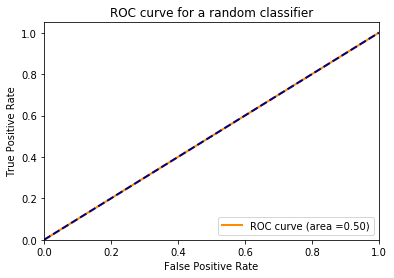

In [56]:
y_dumb = np.zeros((len(y_test), 1))
baseline = skl.metrics.confusion_matrix(y_test, y_dumb)
print(baseline)
plot_roc(y_test, y_dumb, 'ROC curve for a random classifier')

# 3. Training a Support Vector Classifier

A support vector machine (SVM) is an algorithm that learns by fitting a hyperplane into the problem space such that this hyperplane seperates the two target classes as clearly as possible. Because it might not be possible to find such a plane, two measures are introduced:
 - an error function is introduced which is more than 0 if a specific data point is on the wrong side of the margin. The algorithm will try to minimize this margin.
 - the data might not be linearly separable in the dimensionality of the problem space. The algorithm will then project the problem into a higher-dimension space such that it becomes linearly separable. This is called Kernal trick.


### Representation Construction

In [75]:
# 0. Data Representation: Create the feature matrix and label vector as numpy-Arrays.
X = np.array(dfmain[['humidity', 'dewPoint', 'temperature', 
                    'pressure', 'visibility', 'windSpeed', 
                    'precipIntensity', 'precipProbability', 
                    'dat.cape', 'crosswind', 'ratio']])
y = np.array(dfmain['regulated'])
X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [79]:
# Model Representation
# 1. Instantiate a normalizer. Beware to fit on train, and only tranform on test (Cross Valid will do this for us)
#normer = preprocessing.Normalizer()
normer = preprocessing.StandardScaler()


# 2. Instantiate a Linear Support Vector Classifier.
     # For Hyperparameter tuning, we will pay special attention to class weight due to the imbalanced dataset. 
svm1 = svm.SVC(probability=True, class_weight={1: 10})


# 3. Forge normalizer and classifier into a pipeline. Make sure the pipeline steps are memorizable during the grid search.
cached = mkdtemp()
memory = Memory(cachedir=cached, verbose=1)
pipe_1 = Pipeline(steps=[('normalization', normer), ('svm', svm1)], memory=memory)


# 4. Instantiate Cross Validation
#cv = skl.model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
cv = skl.model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# 5. Instantiate the Grid Search for Hypereparameter Tuning
#    As the normalizer and estimators are hidden in the pipeline, we pass the grid parameters
#    with the '_' notation as described in scikit learn documentation: http://bit.ly/2AlhUaK
#params = [ {"svm__kernel": ["linear"], "svm__C": [1, 10, 100, 1000]}, 
#               {"svm__kernel": ["rbf"], "svm__C": [1, 10, 100, 1000], "svm__gamma": [0.001, 0.0001]} ]
params = [ {"svm__kernel": ["rbf"], "svm__C": [750, 1000, 1250], "svm__gamma": [0.01, 0.008, 0.005, 0.003, 0.001]} ]

grd = GridSearchCV(pipe_1, params, scoring='roc_auc', cv=cv, verbose=2, n_jobs=-1)

### Training

In [80]:
# fit the classifier on training set and predict on test set in one line (takes around 5 minutes):
#y_pred = grd.fit(X_train, y_train).predict(X_test)
y_pred = grd.fit(X_train, y_train).predict_proba(X_test)[:, 1]
# remove the cached normalization:
rmtree(cached)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] svm__C=750, svm__gamma=0.01, svm__kernel=rbf ....................
[CV] svm__C=750, svm__gamma=0.01, svm__kernel=rbf ....................
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(StandardScaler(copy=True, with_mean=True, with_std=True), None, array([[ 0.78    , ...,  0.      ],
       ..., 
       [ 0.63    , ...,  0.764706]]), 
array([0, ..., 1]))
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(StandardScaler(copy=True, with_mean=True, with_std=True), None, array([[ 0.77    , ...,  0.424242],
       ..., 
       [ 0.63    , ...,  0.764706]]), 
array([0, ..., 1]))________________________________________________fit_transform_one - 0.0s, 0.0min

________________________________________________fit_transfor

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   59.4s


[CV] ... svm__C=1000, svm__gamma=0.005, svm__kernel=rbf, total=   3.2s
[CV] svm__C=1000, svm__gamma=0.005, svm__kernel=rbf ..................
[CV] ... svm__C=1000, svm__gamma=0.005, svm__kernel=rbf, total=   3.4s
[CV] svm__C=1000, svm__gamma=0.003, svm__kernel=rbf ..................
[CV] ... svm__C=1000, svm__gamma=0.005, svm__kernel=rbf, total=   3.4s
[CV] svm__C=1000, svm__gamma=0.003, svm__kernel=rbf ..................
[CV] ... svm__C=1000, svm__gamma=0.003, svm__kernel=rbf, total=   2.8s
[CV] svm__C=1000, svm__gamma=0.003, svm__kernel=rbf ..................
[CV] ... svm__C=1000, svm__gamma=0.003, svm__kernel=rbf, total=   2.9s
[CV] svm__C=1000, svm__gamma=0.003, svm__kernel=rbf ..................
[CV] ... svm__C=1000, svm__gamma=0.003, svm__kernel=rbf, total=   2.8s
[CV] svm__C=1000, svm__gamma=0.003, svm__kernel=rbf ..................
[CV] ... svm__C=1000, svm__gamma=0.003, svm__kernel=rbf, total=   2.9s
[CV] svm__C=1000, svm__gamma=0.001, svm__kernel=rbf ..................
[CV] .

[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  2.0min finished


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(StandardScaler(copy=True, with_mean=True, with_std=True), None, array([[ 0.77    , ...,  0.424242],
       ..., 
       [ 0.63    , ...,  0.764706]]), 
array([0, ..., 1]))
________________________________________________fit_transform_one - 0.0s, 0.0min


### Evaluation

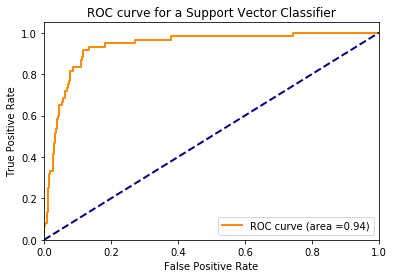

This AUC has been achieved with the following parameters:
{'svm__C': 750, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}
 


In [81]:
#confmatrix = skl.metrics.confusion_matrix(y_test, y_pred)
plot_roc(y_test, y_pred, 'ROC curve for a Support Vector Classifier')
print('This AUC has been achieved with the following parameters:')
print( grd.best_params_ )
print(' ')
#print('The Confusion Matrix for the default threshold is:')
#print(confmatrix)

This plot shows us that the problem is definitely learnable with a simple support verctor classifier. As next step, we are going to replace the SVC with an algorithm capable of online learning. 

# 4. Training an online capable SGD Classifier with partial_fit()

We will now compare above results with another classifier that implements the partial_fit() method. Because of the online characteristic, the construction will be slightly different. In a preliminary step, we will use Grid Search to find parameters applicable for the data at hand. Thereafter, we enable online learning by directly passing the optimum parameters into another, online-capable pipeline.

If we were to implement such an algorithm in production, we should assert that the preliminary step gets sample data from a complete year, so that most climate and traffic conditions are covered when initializing the classifier.

### Pre-Training for Hyperparameter selection

In [86]:
# resetting  the datasets, they might have been messed up by the learner above:
X = np.array(dfmain[['humidity', 'dewPoint', 'temperature', 
                    'pressure', 'visibility', 'windSpeed', 
                    'precipIntensity', 'precipProbability', 
                    'dat.cape', 'crosswind', 'ratio']])
y = np.array(dfmain['regulated'])
X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [87]:
# 1. Instantiate a scaler. Beware to fit on train, and only tranform on test
scaler = preprocessing.StandardScaler()


# 2. Instantiate a Stochastic Gradient Descent Classifier.
     # For Hyperparameter tuning, we will pay special attention to class weight due to the imbalanced dataset.
     # Using modified_huber to make probabilistics available
sgd1 = skl.linear_model.SGDClassifier(loss='log', 
                                      random_state=42, class_weight='balanced', 
                                      warm_start=True, shuffle=True, max_iter=50, tol=0.001)


# 3. Forge scaler and classifier into a pipeline. 
pipe_2 = Pipeline(steps=[('scaling', scaler), ('sgd', sgd1)])

# 4. Instantiate Cross Validation
#cv = skl.model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
cv= skl.model_selection.StratifiedShuffleSplit(n_splits=5, random_state=42)

# 5. Instantiate the Grid Search for Hypereparameter Tuning
#    As the normalizer and estimators are hidden in the pipeline, we pass the grid parameters
#    with the '_' notation as described in scikit learn documentation: http://bit.ly/2AlhUaK
params = {'sgd__alpha': (0.0001, 0.00001, 0.000001), 'sgd__penalty': ('l1', 'l2', 'elasticnet')}
    
grd2 = GridSearchCV(pipe_2, params, scoring='roc_auc', cv=cv, verbose=2, n_jobs=-1)

In [88]:
grd2.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] sgd__alpha=0.0001, sgd__penalty=l1 ..............................
[CV] sgd__alpha=0.0001, sgd__penalty=l1 ..............................
[CV] ............... sgd__alpha=0.0001, sgd__penalty=l1, total=   0.0s
[CV] ............... sgd__alpha=0.0001, sgd__penalty=l1, total=   0.0s
[CV] sgd__alpha=0.0001, sgd__penalty=l1 ..............................
[CV] sgd__alpha=0.0001, sgd__penalty=l1 ..............................
[CV] ............... sgd__alpha=0.0001, sgd__penalty=l1, total=   0.0s
[CV] ............... sgd__alpha=0.0001, sgd__penalty=l1, total=   0.0s
[CV] sgd__alpha=0.0001, sgd__penalty=l1 ..............................
[CV] sgd__alpha=0.0001, sgd__penalty=l2 ..............................
[CV] ............... sgd__alpha=0.0001, sgd__penalty=l1, total=   0.0s
[CV] sgd__alpha=0.0001, sgd__penalty=l2 ..............................
[CV] ............... sgd__alpha=0.0001, sgd__penalty=l2, total=   0.0s
[CV] ............

[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.8s finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size='default',
            train_size=None),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaling', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sgd', SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=50, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=0.001, verbose=0, warm_start=True))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'sgd__alpha': (0.0001, 1e-05, 1e-06), 'sgd__penalty': ('l1', 'l2', 'elasticnet')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

In [89]:
grd2.best_params_

{'sgd__alpha': 0.0001, 'sgd__penalty': 'l1'}

### Representation Construction

We will now instantiate an SGD Classifier with the parameters found in Grid Search and apply partial_fit() for this classifier on the data available.

In [93]:
X = np.array(dfmain[['humidity', 'dewPoint', 'temperature', 
                    'pressure', 'visibility', 'windSpeed', 
                    'precipIntensity', 'precipProbability', 
                    'dat.cape', 'crosswind', 'ratio']])
y = np.array(dfmain['regulated'])
X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [94]:
scaler = preprocessing.StandardScaler()
sgd1 = skl.linear_model.SGDClassifier(loss='log', alpha=0.0001, penalty='l1',
                                      random_state=42, class_weight={1: 12}, 
                                      warm_start=True, shuffle=True, max_iter=50, tol=0.001)

### Training

In [95]:
X_train_t = scaler.fit_transform(X_train)
sgd1.partial_fit(X_train_t, y_train, classes=[0, 1])

SGDClassifier(alpha=0.0001, average=False, class_weight={1: 12}, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=50, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=42, shuffle=True,
       tol=0.001, verbose=0, warm_start=True)

### Evaluation

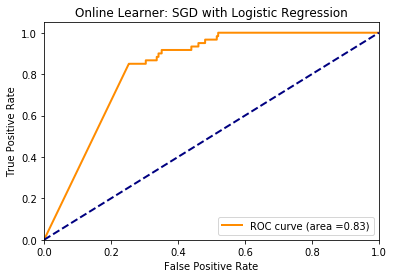

In [96]:
X_test_t = scaler.transform(X_test)
y_pred = sgd1.predict_proba(X_test_t)[:, 1]
plot_roc(y_test, y_pred, 'Online Learner: SGD with Logistic Regression')

The graph shows that we could switch to a classifier that supports online learning. The $AUC$ shows a lower value. Other algorithms, more data or some hyperparameter tuning could improve the result.

# 5. Experimenting with SMOTE (synthetic minority oversampling)

SMOTE has been described for example in [Nguyen2011](http://ousar.lib.okayama-u.ac.jp/files/public/1/19617/20160528004522391723/IWCIA2009_A1005.pdf), and the implementation in scikit-learn-contributions  is available in [Lemaitre2017](http://jmlr.org/papers/v18/16-365). SMOTE is a tachnique with which the original data is enriched by artificial data points belonging to the minority class. These points are placed into the input space neighbouring the original data points such that the boundary that is separating the two classes is sharpened.

This is just an experiment and not reflected in the thesis, because the relation between the SMOTE technique and class weights needs to be further analysed.


### Construction

Comparing to the constructin above, SMOTE is only needed in the preprocessing step.

### Training for Hyperparameter Selection

In [105]:
from imblearn.over_sampling import SMOTE
# resetting  the datasets, they might have been messed up by the learner above:
X = np.array(dfmain[['humidity', 'dewPoint', 'temperature', 
                    'pressure', 'visibility', 'windSpeed', 
                    'precipIntensity', 'precipProbability', 
                    'dat.cape', 'crosswind', 'ratio']])
y = np.array(dfmain['regulated'])
X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE on the training set:
smo = SMOTE(ratio='minority', kind='svm', random_state=42)
X_train, y_train = smo.fit_sample(X_train, y_train)

In [106]:
# 1. Instantiate a scaler. Beware to fit on train, and only tranform on test
scaler = preprocessing.StandardScaler()


# 2. Instantiate a Stochastic Gradient Descent Classifier.
     # For Hyperparameter tuning, we will pay special attention to class weight due to the imbalanced dataset.
     # Using modified_huber to make probabilistics available
sgd2 = skl.linear_model.SGDClassifier(loss='log', 
                                      random_state=42, class_weight=None, 
                                      warm_start=True, shuffle=True, max_iter=50, tol=0.001)


# 3. Forge scaler and classifier into a pipeline. 
pipe_3 = Pipeline(steps=[('scaling', scaler), ('sgd', sgd2)])

# 4. Instantiate Cross Validation
# cv = skl.model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
cv= skl.model_selection.StratifiedShuffleSplit(n_splits=5, random_state=42)

# 5. Instantiate the Grid Search for Hypereparameter Tuning
#    As the normalizer and estimators are hidden in the pipeline, we pass the grid parameters
#    with the '_' notation as described in scikit learn documentation: http://bit.ly/2AlhUaK
params = {'sgd__alpha': (0.0001, 0.00001, 0.000001), 'sgd__penalty': ('l1', 'l2', 'elasticnet')}
    
grd2 = GridSearchCV(pipe_3, params, scoring='roc_auc', cv=cv, verbose=2, n_jobs=-1)

In [107]:
grd2.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] sgd__alpha=0.0001, sgd__penalty=l1 ..............................
[CV] sgd__alpha=0.0001, sgd__penalty=l1 ..............................
[CV] ............... sgd__alpha=0.0001, sgd__penalty=l1, total=   0.0s
[CV] sgd__alpha=0.0001, sgd__penalty=l1 ..............................
[CV] ............... sgd__alpha=0.0001, sgd__penalty=l1, total=   0.0s
[CV] sgd__alpha=0.0001, sgd__penalty=l1 ..............................
[CV] ............... sgd__alpha=0.0001, sgd__penalty=l1, total=   0.0s
[CV] sgd__alpha=0.0001, sgd__penalty=l1 ..............................
[CV] ............... sgd__alpha=0.0001, sgd__penalty=l1, total=   0.0s
[CV] sgd__alpha=0.0001, sgd__penalty=l2 ..............................
[CV] ............... sgd__alpha=0.0001, sgd__penalty=l2, total=   0.0s
[CV] sgd__alpha=0.0001, sgd__penalty=l2 ..............................
[CV] ............... sgd__alpha=0.0001, sgd__penalty=l1, total=   0.1s
[CV] sgd__alpha=0

[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size='default',
            train_size=None),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaling', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sgd', SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=50, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=0.001, verbose=0, warm_start=True))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'sgd__alpha': (0.0001, 1e-05, 1e-06), 'sgd__penalty': ('l1', 'l2', 'elasticnet')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

In [108]:
grd2.best_params_

{'sgd__alpha': 0.0001, 'sgd__penalty': 'l1'}

### Online Learning Example

In [109]:
from imblearn.over_sampling import SMOTE
# resetting  the datasets, they might have been messed up by the learner above:
X = np.array(dfmain[['humidity', 'dewPoint', 'temperature', 
                    'pressure', 'visibility', 'windSpeed', 
                    'precipIntensity', 'precipProbability', 
                    'dat.cape', 'crosswind', 'ratio']])
y = np.array(dfmain['regulated'])
X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE on the training set:
smo = SMOTE(ratio='minority', kind='svm', random_state=42)
X_train, y_train = smo.fit_sample(X_train, y_train)

In [110]:
scaler = preprocessing.StandardScaler()
sgd1 = skl.linear_model.SGDClassifier(loss='log', alpha=0.0001, penalty='l1',
                                      random_state=42, class_weight={1: 12}, 
                                      warm_start=True, shuffle=True, max_iter=50, tol=0.001)


X_train_t = scaler.fit_transform(X_train)
sgd1.partial_fit(X_train_t, y_train, classes=[0, 1])

SGDClassifier(alpha=0.0001, average=False, class_weight={1: 12}, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=50, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=42, shuffle=True,
       tol=0.001, verbose=0, warm_start=True)

### Evaluation

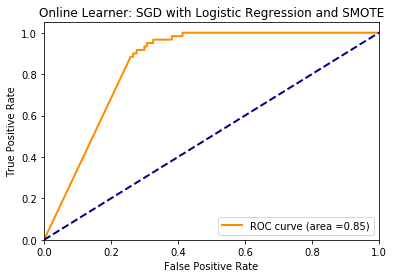

In [111]:
X_test_t = scaler.transform(X_test)
y_pred = sgd1.predict_proba(X_test_t)[:, 1]
plot_roc(y_test, y_pred, 'Online Learner: SGD with Logistic Regression and SMOTE')

Conclusion: The utilization of SMOTE improved the result of the online classifier by 0.02, which is good, but the final performance of the offline algorithm has not yet been met.

# 6. Comparison: training an SVC without Traffic Density Info

The following lines establish an SVC that trains exactly like the one in 3., but does not make use of the traffic density. We want to analyse which effect the traffic density information on the total result has. We expect a clear degradation in performance.

### Construction

In [82]:
# 0. Create the feature matrix and label vector as numpy-Arrays. Leave out Traffic density ('ratio')
X = np.array(dfmain[['humidity', 'dewPoint', 'temperature', 
                    'pressure', 'visibility', 'windSpeed', 
                    'precipIntensity', 'precipProbability', 
                    'dat.cape', 'crosswind']])
y = np.array(dfmain['regulated'])
X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [83]:
# 1. Instantiate a normalizer. Beware to fit on train, and only tranform on test (Cross Valid will do this for us)
#normer = preprocessing.Normalizer()
normer = preprocessing.StandardScaler()


# 2. Instantiate a Linear Support Vector Classifier.
     # For Hyperparameter tuning, we will pay special attention to class weight due to the imbalanced dataset. 
svm1 = svm.SVC(probability=True, class_weight={1: 10})


# 3. Forge normalizer and classifier into a pipeline. Make sure the pipeline steps are memorizable during the grid search.
cached = mkdtemp()
memory = Memory(cachedir=cached, verbose=1)
pipe_1 = Pipeline(steps=[('normalization', normer), ('svm', svm1)], memory=memory)


# 4. Instantiate Cross Validation
cv = skl.model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# 5. Instantiate the Grid Search for Hypereparameter Tuning
#    As the normalizer and estimators are hidden in the pipeline, we pass the grid parameters
#    with the '_' notation as described in scikit learn documentation: http://bit.ly/2AlhUaK
#params = [ {"svm__kernel": ["linear"], "svm__C": [1, 10, 100, 1000]}, 
#               {"svm__kernel": ["rbf"], "svm__C": [1, 10, 100, 1000], "svm__gamma": [0.001, 0.0001]} ]
params = [ {"svm__kernel": ["rbf"], "svm__C": [750, 1000, 1250], "svm__gamma": [0.01, 0.008, 0.005, 0.003, 0.001]} ]

grd = GridSearchCV(pipe_1, params, scoring='roc_auc', cv=cv, verbose=2, n_jobs=-1)

### Training

In [84]:
# fit the classifier on training set and predict on test set in one line (takes around 5 minutes):
#y_pred = grd.fit(X_train, y_train).predict(X_test)
y_pred = grd.fit(X_train, y_train).predict_proba(X_test)[:, 1]
# remove the cached normalization:
rmtree(cached)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] svm__C=750, svm__gamma=0.01, svm__kernel=rbf ....................
[CV] svm__C=750, svm__gamma=0.01, svm__kernel=rbf ....................
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(StandardScaler(copy=True, with_mean=True, with_std=True), None, array([[ 0.78    , ...,  0.308714],
       ..., 
       [ 0.63    , ...,  0.560237]]), 
array([0, ..., 1]))________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(StandardScaler(copy=True, with_mean=True, with_std=True), None, array([[ 0.77    , ...,  0.92    ],
       ..., 
       [ 0.63    , ...,  0.560237]]), 
array([0, ..., 1]))

________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________fit_transfor

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.7min


[CV] ... svm__C=1000, svm__gamma=0.005, svm__kernel=rbf, total=   5.3s
[CV] svm__C=1000, svm__gamma=0.005, svm__kernel=rbf ..................
[CV] ... svm__C=1000, svm__gamma=0.005, svm__kernel=rbf, total=   5.6s
[CV] svm__C=1000, svm__gamma=0.003, svm__kernel=rbf ..................
[CV] ... svm__C=1000, svm__gamma=0.005, svm__kernel=rbf, total=   5.7s
[CV] svm__C=1000, svm__gamma=0.003, svm__kernel=rbf ..................
[CV] ... svm__C=1000, svm__gamma=0.003, svm__kernel=rbf, total=   4.5s
[CV] svm__C=1000, svm__gamma=0.003, svm__kernel=rbf ..................
[CV] ... svm__C=1000, svm__gamma=0.003, svm__kernel=rbf, total=   4.3s
[CV] svm__C=1000, svm__gamma=0.003, svm__kernel=rbf ..................
[CV] ... svm__C=1000, svm__gamma=0.003, svm__kernel=rbf, total=   4.5s
[CV] svm__C=1000, svm__gamma=0.003, svm__kernel=rbf ..................
[CV] ... svm__C=1000, svm__gamma=0.003, svm__kernel=rbf, total=   4.6s
[CV] svm__C=1000, svm__gamma=0.001, svm__kernel=rbf ..................
[CV] .

[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  3.5min finished


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(StandardScaler(copy=True, with_mean=True, with_std=True), None, array([[ 0.77    , ...,  0.92    ],
       ..., 
       [ 0.63    , ...,  0.560237]]), 
array([0, ..., 1]))
________________________________________________fit_transform_one - 0.0s, 0.0min


### Evaluation

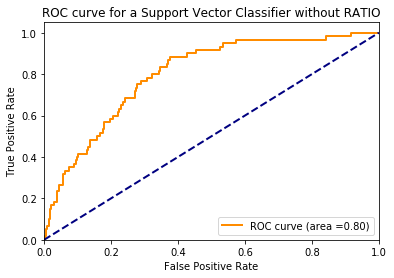

This AUC has been achieved with the following parameters:
{'svm__C': 750, 'svm__gamma': 0.003, 'svm__kernel': 'rbf'}
 


In [85]:
#confmatrix = skl.metrics.confusion_matrix(y_test, y_pred)
plot_roc(y_test, y_pred, 'ROC curve for a Support Vector Classifier without RATIO')
print('This AUC has been achieved with the following parameters:')
print( grd.best_params_ )
print(' ')
#print('The Confusion Matrix for the default threshold is:')
#print(confmatrix)

We observe that leaving out the traffic density will reduce the AUC score to .80. This confirms the correlation between wx regulations and traffic density.